In [3]:
import finesse
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from finesse.components.mechanical import SuspensionZPK
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

finesse.init_plotting()

## Noise Propagation TFs

In [4]:
# Make simple model of a laser and a photodiode
model = finesse.Model()
model.parse(
"""
fsig(1)
l l1 P=1
bs bs1 R=0.5 T=0.5
bs bs2 R=0.5 T=0.5

readout_dc pd1

amplifier A -1M
butter B 2 lowpass 100
link(l1, bs1, pd1, pd1.DC, A, B, l1.amp) 
## servo consists of an amplifier and a Butterworth low pass filter

#zpk ZPK_filter [] [0] 100
#link(l1, bs1, pd1, pd1.DC, ZPK_filter, l1.amp)
## servo could also be specified with a zpk-type filter

# out of loop witness sensor
space s0 bs1.p3 bs2.p1
readout_dc witness bs2.p3.o

#noise laser_amp l1.amp.i 1m/fsig
#noise amplifier A.p2.o A.gain*(0.2m/fsig + 0.0001u*fsig**2)
#noise pd1_dark_noise pd1.DC.o 0.33n
## Noise injection at different locations with their own ASDs
""")

kat = model.deepcopy()
kat.parse("""
noise_projection(
geomspace(10, 1e5, 1000),
#geomspace(10, 5k, 1000),

witness.DC, # out of loop sensor
pd1.DC # in loop sensor
)
""")

# sol = model.run()
# sol.freqresp.plot();
# sol.freqresp.plot_readouts();

# Can also set ASD in python land if you want
# fs = model.fsig.f.ref # symbolic reference
# model.noises.amplifier.ASD = model.G.gain.ref*(0.2e-3/fs + 0.0001e-6*fs**2)

# witnessDC = np.abs(sol.freqresp["witness.DC"])
# pd1DC = np.abs(sol.freqresp["pd1.DC"])
# freq = sol.f
# laser_amp = 1e-3/freq
# amplifier = -10e6*(0.2e-3/freq + 0.0001e-6*freq**2)

In [5]:
# print(sol.freqresp.inputs)
# print(sol.freqresp.outputs)
# print(type(sol.out))
# print(sol.freqresp.out.shape)
# print(sol.freqresp["witness.DC"].shape)
# print(sol.freqresp["pd1.DC"].shape)

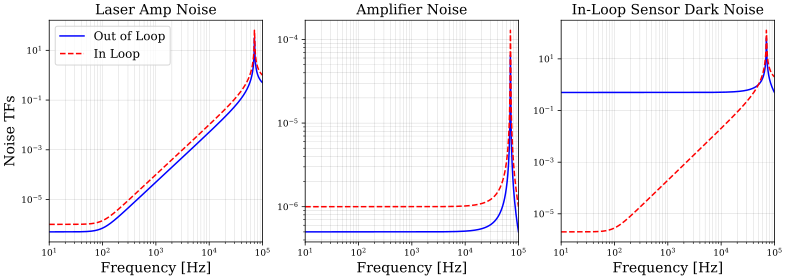

In [7]:
kat1 = kat.deepcopy()
kat1.parse("""
noise laser_amp l1.amp.i 1n
""")
out1 = kat1.run()

kat2 = kat.deepcopy()
kat2.parse("""
noise amplifier A.p2.o 1n
""")
out2 = kat2.run()

kat3 = kat.deepcopy()
kat3.parse("""
noise pd1_dark_noise pd1.DC.o 1n
""")
out3 = kat3.run()
freq = out1.f

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,4))

ax1.loglog(freq, np.abs(out1.freqresp["witness.DC"]), label='Out of Loop')
ax1.loglog(freq, np.abs(out1.freqresp["pd1.DC"]), "--", label='In Loop')

# ax1.loglog(freq, np.abs(out11.freqresp["witness.DC"]), label='Out of Loop')
# ax1.loglog(freq, np.abs(out11.freqresp["pd1.DC"]), "--", label='In Loop')

ax1.set_xlabel('Frequency [Hz]', fontsize=14)
ax2.set_xlabel('Frequency [Hz]', fontsize=14)
ax3.set_xlabel('Frequency [Hz]', fontsize=14)
ax1.set_ylabel('Noise TFs', fontsize=14)
ax1.set_title('Laser Amp Noise', fontsize=14)

ax2.loglog(freq, np.abs(out2.freqresp["witness.DC"]), label='Out of Loop')
ax2.loglog(freq, np.abs(out2.freqresp["pd1.DC"]), "--", label='In Loop')
ax2.set_title('Amplifier Noise', fontsize=14)

ax3.loglog(freq, np.abs(out3.freqresp["witness.DC"]), label='Out of Loop')
ax3.loglog(freq, np.abs(out3.freqresp["pd1.DC"]), "--", label='In Loop')
ax3.set_title('In-Loop Sensor Dark Noise', fontsize=14)

ax1.legend(fontsize=12, ncol=1);
# fig.savefig('FinesseTFs.pdf', bbox_inches='tight', dpi=120, pad_inches=0.01);

<Figure size 576x355.968 with 0 Axes>

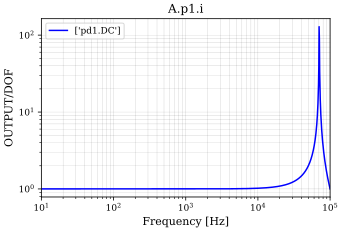

In [8]:
# TFs can also be calculated with frequency_response specifying the noise injection and pick up locations
kat_tf = model.deepcopy()
kat_tf.parse("""
frequency_response(
geomspace(10, 1e5, 1000),
[A.p1.i],  # injection nodes, amplifier noise
[pd1.DC] # output nodes, in loop sensor
)
""")

sol = kat_tf.run()
sol.plot();
# same result as above

## Closed Loop TF (1/(1-G))

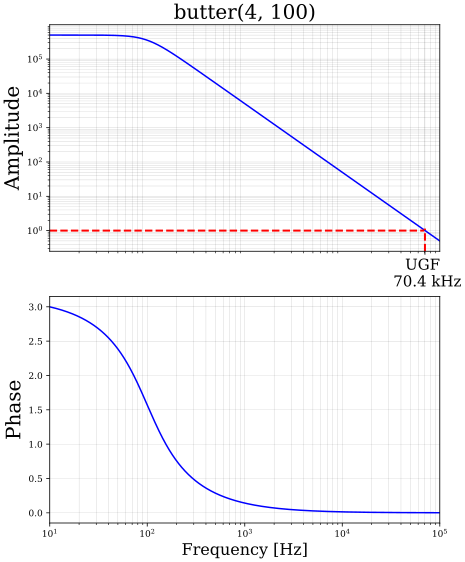

In [16]:
# This is to calculate the Closed Loop TF (1/(1-G)): to verify 
# Noise Propagation TF(N -> PD) = Closed Loop TF * Open Loop TF(N -> PD) 

model = finesse.Model()
model.parse("""
l l1 P=1
readout_dc PD l1.p1.o
sgen sig l1.amp

amplifier A -1M
butter B 2 lowpass 100
link(PD.DC, A, B)

ad filter_out B.p2.o f=fsig
ad filter_butter B.p1.i f=fsig
ad filter_in A.p1.i f=fsig

mathd filter_tf filter_out/filter_in
mathd filter_tf_butter filter_out/filter_butter
mathd filter_tf_amp filter_butter/filter_in
fsig(1)
xaxis(fsig, log, 10, 1e5, 999)
""")
sol = model.run()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,9),)
butter = sol["filter_tf_butter"].astype(complex)
amplifier = sol["filter_tf_amp"].astype(complex)
h = sol["filter_tf"].astype(complex)*0.5
angles = np.unwrap(np.angle(h))
angles_cl = np.unwrap(np.angle(1/(1-h)))
# angles_cla = np.unwrap(np.angle(h/(1-h)))

ax1.loglog(sol.x1, abs(h), label=r"$\mathrm{G}$")
# ax1.loglog(sol.x1, abs(1/(1-h)), label=r"$\mathrm{(1-G)^{-1}}$")
# ax1.loglog(sol.x1, abs(h/(1-h)))

ax2.semilogx(sol.x1, angles)
# ax2.semilogx(sol.x1, angles_cl)
# ax2.semilogx(sol.x1, angles_cla)

# ax1.set_yticks([10**-6, 10**-4, 10**-2, 10**0, 10**2, 10**4, 5*10**5])
# ax1.set_yticklabels([r"$10^{-6}$", r"$10^{-4}$", r"$10^{-2}$", r"$10^{0}$", r"$10^{2}$",
#                      r"$10^{4}$", r"$5 \cdot 10^{5}$",], fontsize=10)

idx = (np.abs(np.abs(h)-1)).argmin()
# xmax = np.log(sol.x1[idx])/np.log(sol.x1.max())
ax1.axhline(y=1, xmin=0, xmax=0.96, color="r", ls="--", lw=2)
# ymax = (np.log(10)-np.log(ax1.get_ylim()[0]))/(np.log(ax1.get_ylim()[1])-np.log(ax1.get_ylim()[0]))
ax1.axvline(x=sol.x1[idx], ymin=0, ymax=0.1, color="r", ls="--", lw=2)

ax1.set_xticks([sol.x1[idx]])
ax1.set_xticklabels([f"UGF \n {sol.x1[idx]/1000:.1f} kHz"], fontsize=15)

ax2.set_xlabel('Frequency [Hz]', fontsize=16)
ax1.set_ylabel('Amplitude', fontsize=20)
ax2.set_ylabel('Phase', fontsize=20)
# ax1.legend(fontsize=14);
ax1.set_title(r'butter(4, 100)', fontsize=20);
# fig.savefig('openloopTF.pdf', bbox_inches='tight', dpi=120, pad_inches=0.01);
# UGF

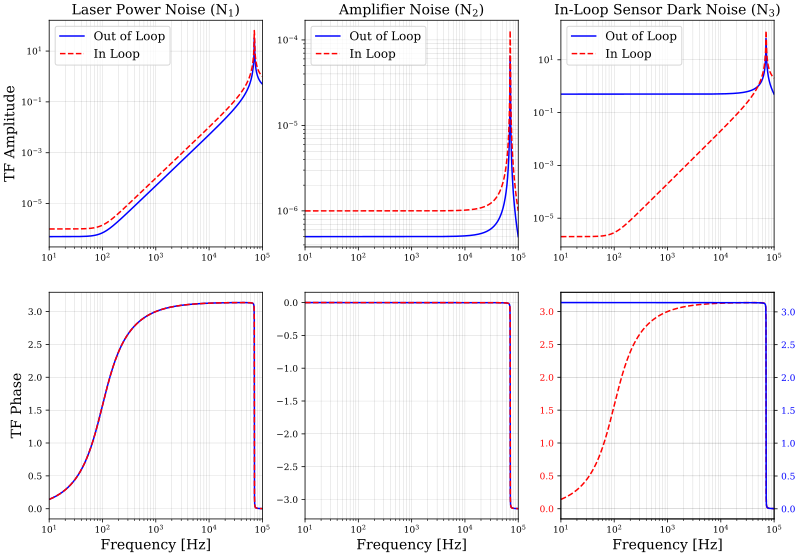

In [17]:
kat1 = kat.deepcopy()
kat1.parse("""
noise laser_amp l1.amp.i 1n
""")
out1 = kat1.run()

kat2 = kat.deepcopy()
kat2.parse("""
noise amplifier A.p2.o 1n
""")
out2 = kat2.run()

kat3 = kat.deepcopy()
kat3.parse("""
noise pd1_dark_noise pd1.DC.o 1n
""")
out3 = kat3.run()
freq = out1.f

fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(13,9))

ax1.loglog(freq, np.abs(out1.freqresp["witness.DC"]), label='Out of Loop')
ax1.loglog(freq, np.abs(out1.freqresp["pd1.DC"]), "--", label='In Loop')

ax4.semilogx(freq, np.unwrap(np.angle(out1.freqresp["witness.DC"])), label='Out of Loop')
ax4.semilogx(freq, np.unwrap(np.angle(out1.freqresp["pd1.DC"])), "--", label='In Loop')

ax4.set_xlabel('Frequency [Hz]', fontsize=14)
ax5.set_xlabel('Frequency [Hz]', fontsize=14)
ax6.set_xlabel('Frequency [Hz]', fontsize=14)
ax1.set_ylabel('TF Amplitude', fontsize=14)
ax4.set_ylabel('TF Phase', fontsize=14)
ax1.set_title(r'Laser Power Noise $\mathrm{(N_1)}$', fontsize=14)

ax2.loglog(freq, np.abs(out2.freqresp["witness.DC"]), label='Out of Loop')
ax2.loglog(freq, np.abs(out2.freqresp["pd1.DC"]), "--", label='In Loop')

ax5.semilogx(freq, np.unwrap(np.angle(out2.freqresp["witness.DC"])), label='Out of Loop')
ax5.semilogx(freq, np.unwrap(np.angle(out2.freqresp["pd1.DC"])), "--", label='In Loop')

ax2.set_title(r'Amplifier Noise $\mathrm{(N_2)}$', fontsize=14)

ax3.loglog(freq, np.abs(out3.freqresp["witness.DC"]), label='Out of Loop')
ax3.loglog(freq, np.abs(out3.freqresp["pd1.DC"]), "--", label='In Loop')

ax6.semilogx(freq, np.unwrap(np.angle(out3.freqresp["pd1.DC"])), "r--", label='In Loop')

ax7 = ax6.twinx()
ax7.semilogx(freq, np.unwrap(np.angle(out3.freqresp["witness.DC"])), '-', label='Out of Loop')

ax6.tick_params(axis='y', labelcolor="red")
ax7.tick_params(axis='y', labelcolor="blue")

ax3.set_title(r'In-Loop Sensor Dark Noise $\mathrm{(N_3)}$', fontsize=14)

ax1.legend(fontsize=12, ncol=1);
ax2.legend(fontsize=12, ncol=1);
ax3.legend(fontsize=12, ncol=1);
# fig.savefig('FinesseTFsUN.pdf', bbox_inches='tight', dpi=120, pad_inches=0.01);

# Noise Propagation TF(N -> PD) = Closed Loop TF * Open Loop TF(N -> PD) 

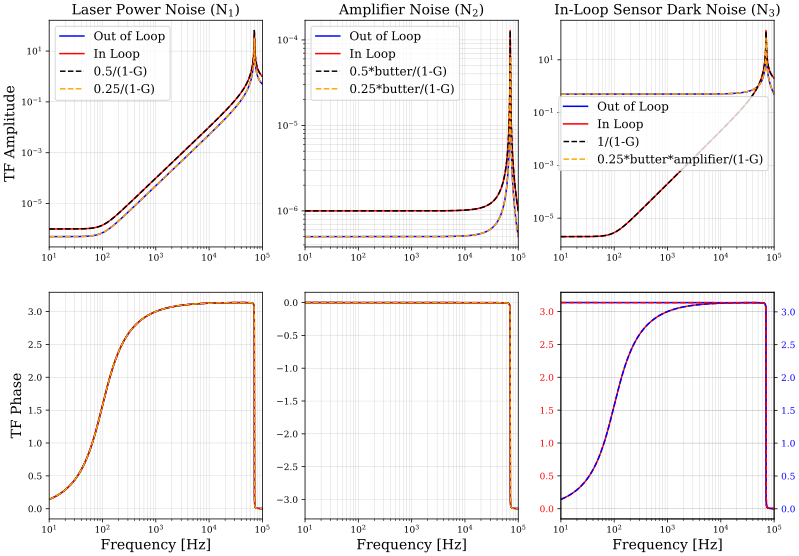

In [18]:
kat1 = kat.deepcopy()
kat1.parse("""
noise laser_amp l1.amp.i 1n
""")
out1 = kat1.run()

kat2 = kat.deepcopy()
kat2.parse("""
noise amplifier A.p2.o 1n
""")
out2 = kat2.run()

kat3 = kat.deepcopy()
kat3.parse("""
noise pd1_dark_noise pd1.DC.o 1n
""")
out3 = kat3.run()
freq = out1.f

fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(13,9))

ax1.loglog(freq, np.abs(out1.freqresp["witness.DC"]), label='Out of Loop')
ax1.loglog(freq, np.abs(out1.freqresp["pd1.DC"]), "-", label='In Loop')

ax1.loglog(freq, np.abs(0.5/(1-h)), "--", label='0.5/(1-G)')
ax1.loglog(freq, np.abs(0.25/(1-h)), "--", label='0.25/(1-G)')

ax4.semilogx(freq, np.unwrap(np.angle(out1.freqresp["witness.DC"])), label='Out of Loop')
ax4.semilogx(freq, np.unwrap(np.angle(out1.freqresp["pd1.DC"])), "-", label='In Loop')

ax4.semilogx(freq, np.unwrap(np.angle(0.5/(1-h))), "--", label='-.')
ax4.semilogx(freq, np.unwrap(np.angle(0.25/(1-h))), "--", label='')

ax4.set_xlabel('Frequency [Hz]', fontsize=14)
ax5.set_xlabel('Frequency [Hz]', fontsize=14)
ax6.set_xlabel('Frequency [Hz]', fontsize=14)
ax1.set_ylabel('TF Amplitude', fontsize=14)
ax4.set_ylabel('TF Phase', fontsize=14)
ax1.set_title(r'Laser Power Noise $\mathrm{(N_1)}$', fontsize=14)

ax2.loglog(freq, np.abs(out2.freqresp["witness.DC"]), label='Out of Loop')
ax2.loglog(freq, np.abs(out2.freqresp["pd1.DC"]), "-", label='In Loop')

ax2.loglog(freq, np.abs(0.5*butter/(1-h)), "--", label='0.5*butter/(1-G)')
ax2.loglog(freq, np.abs(0.25*butter/(1-h)), "--", label='0.25*butter/(1-G)')

ax5.semilogx(freq, np.unwrap(np.angle(out2.freqresp["witness.DC"])), label='Out of Loop')
ax5.semilogx(freq, np.unwrap(np.angle(out2.freqresp["pd1.DC"])), "-", label='In Loop')

ax5.semilogx(freq, np.unwrap(np.angle(0.5*butter/(1-h))), "--", label='Out of Loop')
ax5.semilogx(freq, np.unwrap(np.angle(0.25*butter/(1-h))), "--", label='In Loop')

ax2.set_title(r'Amplifier Noise $\mathrm{(N_2)}$', fontsize=14)

ax3.loglog(freq, np.abs(out3.freqresp["witness.DC"]), label='Out of Loop')
ax3.loglog(freq, np.abs(out3.freqresp["pd1.DC"]), "-", label='In Loop')

ax3.loglog(freq, np.abs(1/(1-h)), "--", label='1/(1-G)')
ax3.loglog(freq, np.abs(0.25*butter*amplifier/(1-h)), "--", label='0.25*butter*amplifier/(1-G)')

ax6.semilogx(freq, np.unwrap(np.angle(out3.freqresp["pd1.DC"])), "r-", label='In Loop')
ax6.semilogx(freq, np.unwrap(np.angle(1/(1-h))), "--", label='')

ax7 = ax6.twinx()
ax7.semilogx(freq, np.unwrap(np.angle(out3.freqresp["witness.DC"])), '-', label='Out of Loop')
ax7.semilogx(freq, np.unwrap(np.angle(0.25*butter*amplifier/(1-h))), "--", label='')

ax6.tick_params(axis='y', labelcolor="red")
ax7.tick_params(axis='y', labelcolor="blue")

ax3.set_title(r'In-Loop Sensor Dark Noise $\mathrm{(N_3)}$', fontsize=14)

ax1.legend(fontsize=12, ncol=1);
ax2.legend(fontsize=12, ncol=1);
ax3.legend(fontsize=12, ncol=1);
# fig.savefig('results.pdf', bbox_inches='tight', dpi=120, pad_inches=0.01);

## Total Noise (summed noise in quadrature):
$$
\begin{array}{c}
\mathrm{T} . \mathrm{N} .=\sqrt{\mathrm{N}_1^2+\mathrm{N}_2^2+\mathrm{N}_3^2} \\
\text { where } \mathrm{N}=\mathrm{N}_{\mathrm{input}} \cdot \mathrm{TF}
\end{array}
$$

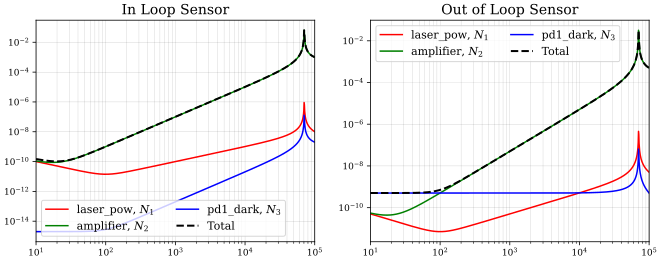

In [10]:
# the laser amp noise is 1mW/sqrt(Hz) at 10 kHz

kat1 = kat.deepcopy()
kat1.parse("""
noise laser_pow l1.amp.i 1m/fsig # N1
noise amplifier A.p2.o (1m/fsig + 0.1u*fsig**2) # N2
noise pd1_dark pd1.DC.o 1n # N3
""")
out1 = kat1.run()

colors = ["r", "g", "b", "y", "orange"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))

noises = out1.noises
for idx, noise in enumerate(noises):
    ax1.loglog(freq, out1.out["pd1.DC"][:, idx], color=colors[idx], label=rf"{noise}, $N_{idx+1}$")
    ax2.loglog(freq, out1.out["witness.DC"][:, idx], color=colors[idx], label=rf"{noise}, $N_{idx+1}$")
    
total_pd1 = np.sqrt((out1.out["pd1.DC"] ** 2).sum(1))
total_wit = np.sqrt((out1.out["witness.DC"] ** 2).sum(1))
ax1.loglog(freq, total_pd1, c="k", ls="--", lw=2, label="Total")
ax2.loglog(freq, total_wit, c="k", ls="--", lw=2, label="Total")

ax1.set_title('In Loop Sensor', fontsize=14)
ax2.set_title('Out of Loop Sensor', fontsize=14)

ax1.legend(fontsize=11, loc="lower left", ncol=2)
ax2.legend(fontsize=11, ncol=2);
# fig.savefig('totalnoise.pdf', bbox_inches='tight', dpi=120, pad_inches=0.01);

## Total Noise vs. Amplifier Gain -- Loop Optimization

In [11]:
a = np.concatenate((-np.logspace(6, 0, 30), np.logspace(0, 6, 30)))

In [12]:
def totalNoise(gain):
    kat1 = kat.deepcopy()
    kat1.A.gain = gain
    kat1.parse("""
    noise laser_pow l1.amp.i 1m/fsig # N1
    noise amplifier A.p2.o (1m/fsig + 0.1u*fsig**2) # N2
    noise pd1_dark pd1.DC.o 1n # N3
    """)
    out1 = kat1.run()
    
    total_wit = np.sqrt((out1.out["witness.DC"] ** 2).sum(1))
    
    return total_wit

TotalNoisep = []
TotalNoisen = []
# gains = np.concatenate((-np.logspace(6, 0, 30), np.logspace(0, 6, 30)))
gainns = -np.logspace(0, 8, 30)
for idx, gain in enumerate(gainns):
    TN = totalNoise(gain)
    TotalNoisen.append(TN)
    
gainps = np.logspace(0, 8, 30)
for idx, gain in enumerate(gainps):
    TN = totalNoise(gain)
    TotalNoisep.append(TN)

/var/folders/2z/nfy5w7t539z0d0s39r98jl3h0000gn/T/ipykernel_62984/33074730.py:19: MatplotlibDeprecationWarning: The 'update_ticks' parameter of set_ticks() was deprecated in Matplotlib 3.5 and will be removed two minor releases later. If any parameter follows 'update_ticks', they should be passed as keyword, not positionally.
  cbar.set_ticks([0, 0.25, 0.5, 0.75, 1], update_ticks=True)


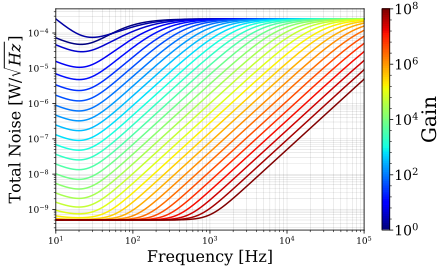

In [13]:
colormap = cm.get_cmap('jet')
colors = colormap(np.linspace(0, 1, 30))
fig, ax = plt.subplots(1,1, figsize=(6,4))

for idx, gain in enumerate(gainps):
    ax.loglog(out1.f, TotalNoisep[idx], label=int(gain), color=colors[idx])
ax.set_xlabel('Frequency [Hz]', fontsize=16)
ax.set_ylabel(r'Total Noise [W/$\sqrt{Hz}$]', fontsize=16)


cmap = plt.cm.get_cmap('jet', 100)
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
# # and use this scalarmappable to create a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2.5%", pad=0.25)
cbar = plt.colorbar(sm, cax=cax, norm=matplotlib.colors.LogNorm(vmin=0, vmax=1))
cbar.set_label(label="Gain", fontsize=20, rotation=90, labelpad=2)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1], update_ticks=True)
cbar.set_ticklabels([r"$10^{0}$", r"$10^{2}$", r"$10^{4}$", r"$10^{6}$", r"$10^{8}$"])
cbar.ax.minorticks_on()
cbar.ax.tick_params(labelsize=14, rotation=0, pad=1);
# fig.savefig('noisegainp.pdf', bbox_inches='tight', dpi=120, pad_inches=0.01);

/var/folders/2z/nfy5w7t539z0d0s39r98jl3h0000gn/T/ipykernel_62984/1528991629.py:18: MatplotlibDeprecationWarning: The 'update_ticks' parameter of set_ticks() was deprecated in Matplotlib 3.5 and will be removed two minor releases later. If any parameter follows 'update_ticks', they should be passed as keyword, not positionally.
  cbar.set_ticks([0, 0.25, 0.5, 0.75, 1], update_ticks=True)


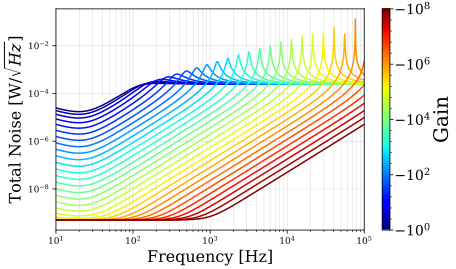

In [14]:
colormap = cm.get_cmap('jet')
colors = colormap(np.linspace(0, 1, 30))
fig, ax = plt.subplots(1,1, figsize=(6,4))

for idx, gain in enumerate(gainns):
    ax.loglog(out1.f, TotalNoisen[idx], label=int(gain), color=colors[idx])
ax.set_xlabel('Frequency [Hz]', fontsize=16)
ax.set_ylabel(r'Total Noise [W/$\sqrt{Hz}$]', fontsize=16)

cmap = plt.cm.get_cmap('jet', 100)
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
# # and use this scalarmappable to create a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2.5%", pad=0.25)
cbar = plt.colorbar(sm, cax=cax, norm=matplotlib.colors.LogNorm(vmin=0, vmax=1))
cbar.set_label(label="Gain", fontsize=20, rotation=90, labelpad=2)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1], update_ticks=True)
cbar.set_ticklabels([r"$-10^{0}$", r"$-10^{2}$", r"$-10^{4}$", r"$-10^{6}$", r"$-10^{8}$"])
cbar.ax.minorticks_on()
cbar.ax.tick_params(labelsize=14, rotation=0, pad=1);
# fig.savefig('noisegainn.pdf', bbox_inches='tight', dpi=120, pad_inches=0.01);

## A more complicated setup

In [15]:
IMCkat = finesse.Model()
IMCkat.parse(
"""
var Larm 4000
var Rcarm 2500

# Add a Laser named L0 with a power of 1 W.
l l1 P=1

s s1 portA=l1.p1 portB=ITMy.p1
#s s1 portA=l1.p1 portB=eo1.p1
#mod eo1 9M 0.3 order=1
#s s2 eo1.p2 ITMy.p1 L=0

m ITMy T=0.005 L=5e-5 phi=0 Rc=inf#-Rcarm
s LY ITMy.p2 ETMy.p1 L=Larm
m ETMy T=5e-6 L=5e-5 phi=0 Rc=inf#Rcarm

# cavity
#cavity cav source=ITMy.p2

fsig(1)
#readout_rf pd1 ITMy.p1.o f=eo1.f phase=0 output_detectors=True

readout_dc pd1 ITMy.p1.o

amplifier A -1M
butter B 4 lowpass 100
link(pd1.DC, A, B, l1.amp)

#zpk ZPK_filter [] [0,0] gain=100
#link(pd1.DC, ZPK_filter, l1.amp)

#noise laser_amp_noise L0.amp.i 1m/fsig
#noise servo_noise ZPK_filter.p2.o ZPK_filter.gain*(0.2m/fsig + 0.0001u*fsig**2)
#noise pd1_dark_noise pd1.DC.o 0.33n

readout_dc witness ETMy.p2.o
"""
)

# IMCkat.add(SuspensionZPK('ITMy_sus', IMCkat.ITMy.mech, [], [0,0], 1/40))
# IMCkat.add(SuspensionZPK('ETMy_sus', IMCkat.ETMy.mech, [], [0,0], 1/40))

kat = IMCkat.deepcopy()
kat.parse("""
noise_projection(
geomspace(0.1, 100k, 2000),
witness.DC, # out of loop
pd1.DC # in loop
)
""")

# witnessDC = np.abs(sol.freqresp["witness.DC"])
# pd1DC = np.abs(sol.freqresp["pd1.DC"])
# freq = sol.f
# laser_amp = 1e-4/freq
# amplifier = 100*(0.2e-3/freq + 0.0001e-6*freq**2)

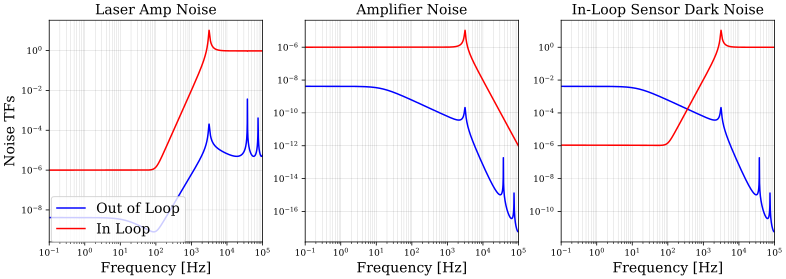

In [16]:
kat1 = kat.deepcopy()
kat1.parse("""
noise laser_amp l1.amp.i 1m/fsig
""")
out1 = kat1.run()

kat2 = kat.deepcopy()
kat2.parse("""
noise amplifier A.p2.o A.gain*(0.2m/fsig + 0.0001u*fsig**2)
#noise amplifier ZPK_filter.p2.o ZPK_filter.gain*(0.2m/fsig + 0.0001u*fsig**2)
""")
out2 = kat2.run()

kat3 = kat.deepcopy()
kat3.parse("""
noise pd1_dark_noise pd1.DC.o 0.33n
""")
out3 = kat3.run()
freq = out1.f

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,4))

ax1.loglog(freq, np.abs(out1.freqresp["witness.DC"]), label='Out of Loop')
ax1.loglog(freq, np.abs(out1.freqresp["pd1.DC"]), "-", label='In Loop')

ax1.set_xlabel('Frequency [Hz]', fontsize=14)
ax2.set_xlabel('Frequency [Hz]', fontsize=14)
ax3.set_xlabel('Frequency [Hz]', fontsize=14)
ax1.set_ylabel('Noise TFs', fontsize=14)
ax1.set_title('Laser Amp Noise', fontsize=14)

ax2.loglog(freq, np.abs(out2.freqresp["witness.DC"]), label='Out of Loop')
ax2.loglog(freq, np.abs(out2.freqresp["pd1.DC"]), "-", label='In Loop')
ax2.set_title('Amplifier Noise', fontsize=14)

ax3.loglog(freq, np.abs(out3.freqresp["witness.DC"]), label='Out of Loop')
ax3.loglog(freq, np.abs(out3.freqresp["pd1.DC"]), "-", label='In Loop')
ax3.set_title('In-Loop Sensor Dark Noise', fontsize=14)

ax1.legend(fontsize=14, loc=(0.01, 0.), ncol=1);

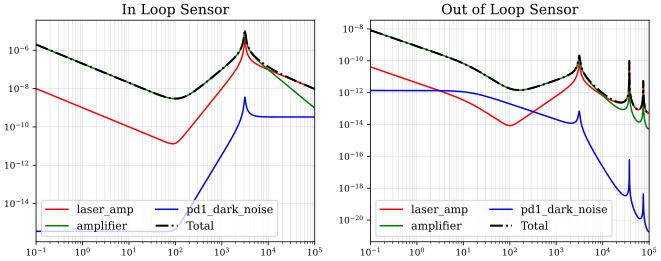

In [17]:
kat1 = kat.deepcopy()
kat1.parse("""
noise laser_amp l1.amp.i 1m/fsig
noise amplifier A.p2.o A.gain*(0.2m/fsig + 0.0001u*fsig**2)*1m
noise pd1_dark_noise pd1.DC.o 0.33n

""")
out1 = kat1.run()

colors = ["r", "g", "b", "y", "orange"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))

noises = out1.noises
for idx, noise in enumerate(noises):
    ax1.loglog(freq, out1.out["pd1.DC"][:, idx], color=colors[idx], label=f"{noise}")
    ax2.loglog(freq, out1.out["witness.DC"][:, idx], color=colors[idx], label=f"{noise}")
    
total_pd1 = np.sqrt((out1.out["pd1.DC"] ** 2).sum(1))
total_wit = np.sqrt((out1.out["witness.DC"] ** 2).sum(1))
ax1.loglog(freq, total_pd1, c="k", ls="-.", lw=2, label="Total")
ax2.loglog(freq, total_wit, c="k", ls="-.", lw=2, label="Total")

ax1.set_title('In Loop Sensor', fontsize=14)
ax2.set_title('Out of Loop Sensor', fontsize=14)

ax1.legend(fontsize=11, loc="lower left", ncol=2)
ax2.legend(fontsize=11, ncol=2);